<a href="https://colab.research.google.com/github/BrianBehnke/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-3-select-models-and-parameters/LS_DS_243_Select_models_and_parameters_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using data I used for my Sprint 1 Project on NFL scoring vs salary. 

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 3.8MB/s 


In [0]:
import category_encoders as ce

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
df = pd.read_csv('drive/My Drive/NFLdataNumerical.csv')
df.head()

,Number of Records,Passing TDs,Player,Position,Pts,Salary,Team,Points
0,1,0,A.J. Derby,TE,12,705000,2TM,12
1,1,0,A.J. Green,WR,48,10550000,CIN,48
2,1,0,Aaron Jones,RB,24,489706,GNB,24
3,1,0,Adam Humphries,WR,6,2914000,TAM,6
4,1,0,Adam Shaheen,TE,18,733661,CHI,18


In [19]:
df = df.drop('Number of Records', 1)
df = df.drop('Player', 1)
df = df.drop('Position', 1)
df = df.drop('Team', 1)
df.head()

,Passing TDs,Pts,Salary,Points
0,0,12,705000,12
1,0,48,10550000,48
2,0,24,489706,24
3,0,6,2914000,6
4,0,18,733661,18


In [20]:
df.describe()

,Passing TDs,Pts,Salary,Points
count,408.000000,408.000000,4.080000e+02,408.000000
mean,1.041667,24.254902,2.411662e+06,30.504902
std,4.625082,29.065016,3.137377e+06,38.841390
min,0.000000,1.000000,1.216000e+05,1.000000
25%,0.000000,6.000000,6.375000e+05,6.000000
50%,0.000000,12.000000,1.000000e+06,12.000000
75%,0.000000,30.000000,2.517500e+06,36.000000
max,34.000000,158.000000,2.250000e+07,222.000000


In [21]:
df.shape

(408, 4)

In [0]:
train = df[:-100]
test = df[-100:]

In [0]:
X_train = train.drop(columns='Salary')
y_train = train.Salary

X_test  = test.drop(columns='Salary')
y_test  = test.Salary

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


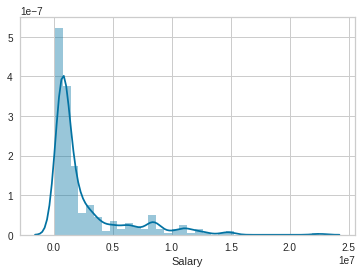

In [43]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [44]:
y_train.describe()

count    3.080000e+02
mean     2.572448e+06
std      3.298218e+06
min      1.216000e+05
25%      6.544348e+05
50%      1.000000e+06
75%      2.923000e+06
max      2.250000e+07
Name: Salary, dtype: float64

In [45]:
y_pred = np.full(shape=y_train.shape, fill_value=y_train.mean())
mean_absolute_error(y_train, y_pred)

2338784.824485579

In [46]:
mean_absolute_error(y_train, X_train.Points)

2572416.987012987

In [47]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

pd.DataFrame(scores)

,estimator,fit_time,score_time,test_score,train_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.006779,0.002124,-2.034972e+06,-2.373604e+06
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.001963,0.000992,-2.390868e+06,-2.126398e+06
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.002007,0.001165,-2.314118e+06,-2.074600e+06


In [48]:
scores['test_score'].mean()

-2246652.8521344657

In [50]:
for i, model in enumerate(scores['estimator']):
    coefficients = model.coef_
    intercept = model.intercept_
    feature_names = X_train.columns
    
    print('Model from cross validation fold #' + str(i))
    print('Intercept', model.intercept_)
    print(pd.Series(coefficients, feature_names).to_string())
    print('\n')

Model from cross validation fold #0
Intercept 2410806.320491029
Passing TDs    10230.472954
Pts           -30100.061739
Points         31282.775987


Model from cross validation fold #1
Intercept 2246521.128146708
Passing TDs    16952.943995
Pts           -50583.590909
Points         51134.073059


Model from cross validation fold #2
Intercept 2234201.246612825
Passing TDs     7901.801418
Pts           -24329.454511
Points         23081.353998




In [52]:
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     18.42
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           2.80e-08
Time:                        23:55:11   Log-Likelihood:                -5041.7
No. Observations:                 308   AIC:                         1.009e+04
Df Residuals:                     305   BIC:                         1.010e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.292e+06   2.41e+05      9.490      

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [54]:
for degree in [0, 1, 2, 3]:
    features = PolynomialFeatures(degree).fit(X_train).get_feature_names(X_train.columns)
    print(f'{degree} degree polynomial has {len(features)} features')
    print(features)
    print('\n')

0 degree polynomial has 1 features
['1']


1 degree polynomial has 4 features
['1', 'Passing TDs', 'Pts', 'Points']


2 degree polynomial has 10 features
['1', 'Passing TDs', 'Pts', 'Points', 'Passing TDs^2', 'Passing TDs Pts', 'Passing TDs Points', 'Pts^2', 'Pts Points', 'Points^2']


3 degree polynomial has 20 features
['1', 'Passing TDs', 'Pts', 'Points', 'Passing TDs^2', 'Passing TDs Pts', 'Passing TDs Points', 'Pts^2', 'Pts Points', 'Points^2', 'Passing TDs^3', 'Passing TDs^2 Pts', 'Passing TDs^2 Points', 'Passing TDs Pts^2', 'Passing TDs Pts Points', 'Passing TDs Points^2', 'Pts^3', 'Pts^2 Points', 'Pts Points^2', 'Points^3']




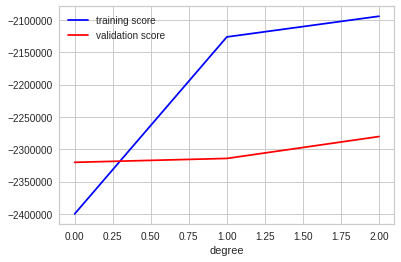

In [55]:
from sklearn.model_selection import validation_curve

degree = [0, 1, 2]
train_score, val_score = validation_curve(
    PolynomialRegression(), X_train, y_train,
    param_name='polynomialfeatures__degree', param_range=degree, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('degree');

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': [0, 1, 2, 3]
}

gridsearch = GridSearchCV(PolynomialRegression(), param_grid=param_grid, 
                          scoring='neg_mean_absolute_error', cv=3, 
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-2227374.408950982, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-2320127.90475965, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-2490191.5626308764, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-2034971.6047059277, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-2390868.4552530893, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-2314118.4964443804, total=   0.0s
[CV] polynomialfeatures__degree=2 .....................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` param

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomialfeatures__degree': [0, 1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [57]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_polynomialfeatures__degree,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.003258,0.001164,-2.200859e+06,-2.147945e+06,2,{'polynomialfeatures__degree': 2},1,-2.006486e+06,-2.321402e+06,-2.316563e+06,-2.094441e+06,-2.280298e+06,-2.027993e+06,0.000410,0.000051,138568.689235,125616.619839
1,0.003293,0.001082,-2.246434e+06,-2.191534e+06,1,{'polynomialfeatures__degree': 1},2,-2.034972e+06,-2.373604e+06,-2.390868e+06,-2.126398e+06,-2.314118e+06,-2.074600e+06,0.000030,0.000042,153125.236350,130468.344035
3,0.003980,0.001273,-2.317293e+06,-2.102853e+06,3,{'polynomialfeatures__degree': 3},3,-2.291785e+06,-2.222331e+06,-2.334560e+06,-2.040653e+06,-2.325616e+06,-2.045574e+06,0.000078,0.000048,18445.575621,84507.691130
0,0.004263,0.001323,-2.345429e+06,-2.337932e+06,0,{'polynomialfeatures__degree': 0},4,-2.227374e+06,-2.471032e+06,-2.320128e+06,-2.399843e+06,-2.490192e+06,-2.142922e+06,0.001624,0.000340,108696.029113,140922.490575


In [59]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=20)

scores = cross_validate(model, X_train, y_train, 
                        scoring='neg_mean_absolute_error', 
                        cv=3, return_train_score=True, 
                        return_estimator=True)

pd.DataFrame(scores)

,estimator,fit_time,score_time,test_score,train_score
0,"(DecisionTreeRegressor(criterion='mse', max_de...",0.074844,0.006090,-2.164717e+06,-1.976215e+06
1,"(DecisionTreeRegressor(criterion='mse', max_de...",0.072129,0.006097,-2.304953e+06,-1.794821e+06
2,"(DecisionTreeRegressor(criterion='mse', max_de...",0.071269,0.005955,-2.623993e+06,-1.692032e+06


In [60]:
scores['test_score'].mean()

-2364554.346733749

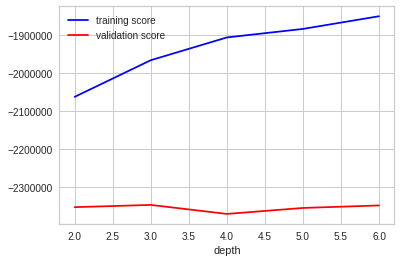

In [61]:
model = RandomForestRegressor(n_estimators=100)

depth = [2, 3, 4, 5, 6]
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

In [62]:
%%time

param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [4, 5], 
    'criterion': ['mse', 'mae']
}

gridsearch = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, 
                          scoring='neg_mean_absolute_error', cv=3, 
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-2090006.293526633, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-2376753.4552119933, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-2447850.023010194, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................
[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-2070549.7062650295, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-2356808.959921797, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................
[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-2419402.823436865, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-2098186.5939228907, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-2336796.566594858, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-2469219.343201895, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-2085910.2315498986, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-2341540.956669595, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-2473474.1761482228, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-1619924.5800970874, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-2074814.873495146, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-2112225.4055882352, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=200 ....................
[CV]  criterion=ma

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    4.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 4.47 s, sys: 27.1 ms, total: 4.49 s
Wall time: 4.5 s


In [63]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from grid search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

Best result from grid search of 8 parameter combinations


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.263429,0.010164,-1.932714e+06,-1.650776e+06,mae,4,200,"{'criterion': 'mae', 'max_depth': 4, 'n_estima...",1,-1.629891e+06,-1.797715e+06,-2.063504e+06,-1.626574e+06,-2.106435e+06,-1.528040e+06,0.003664,0.000152,215363.189417,111416.526357
